In [2]:
## BEGIN
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{ "size":16}) #**{,,'serif':['Palatino']
rc('text', usetex=True)
import numpy.random as rnd
rnd.seed()
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import pickle as cp
import scipy.optimize as opt
from scipy.optimize import curve_fit as fit
#import mps
import cProfile
import subprocess
from scipy.special import hyp2f1, erf
from scipy.optimize import brentq

import itertools

In [61]:
def prepare_graph(L, cut_boundary = 0, **kwargs):
    xy2i = lambda x,y:x*L + y
    xs, ys =  np.arange(L**2) // L, np.arange(L**2) % L
    xp, xm = (xs + 1) % L, (xs - 1) % L
    yp, ym = (ys + 1) % L, (ys - 1) % L


    matrix = sp.coo_matrix((L**2, L**2), dtype= int)
    inds = np.array([ xy2i(xp, ys), xy2i(xm, ys), 
                     xy2i(xs , yp), xy2i(xs, ym)]).T.reshape(-1)
    data = np.ones_like(inds, dtype=int)
    indptr = np.arange(L ** 2 + 1) * 4
    full_graph = sp.csc_matrix((data, inds, indptr),shape=(L**2, L**2))

    ## cut all the boundaries
    if 0:
        lil = full_graph.tolil()
        lil[:L, -L:] = 0
        lil[-L:, :L] = 0
        lil[::L, L-1::L] = 0
        lil[L-1::L, ::L] = 0
        full_graph = lil.tocsc()
    ##############

    edges = sp.coo_matrix(full_graph)
    ut_ind = edges.row > edges.col
    edges = sp.coo_matrix((edges.data[ut_ind], (edges.row[ut_ind], edges.col[ut_ind])), shape = (L**2,L**2))
    #degree = np.diff(full_graph.indptr)
    return full_graph, edges

# Ising model on the square lattice

##  Fortuin-Kasterleyn (FK) cluster Monte Carlo (optional)

For the curious, I am using a cluster algorithm based on the Fortuin-Kasterleyn (FK) representation. 
It is a slightly different high-$T$ expansion of the Ising model. One starts by rewriting the Boltzmann weight on a bond as follows
$$ e^{K \sigma \sigma'} \propto (1 + x \delta_{\sigma, \sigma'}) \,,\, x = e^{2K}-1 $$
Doing this for all bonds, we obtain an expansion of the partition function as a sum of "FK cluster" configurations. The relative weight of a FK cluster configuration is 
$$ w^{\text{number of active bonds}} (1-w)^{\text{number of inactive bonds}} Q^{\text{number of clusters}} $$
where 
$$ w = \frac{x}{1+x} = 1-e^{-2K} $$
and $$Q = 2 \; \text{(Ising)}$$
(For general $Q$, we get the $Q$-state Potts model). The active bonds are the ones we chose the term $\delta_{\sigma, \sigma'}$; a cluster is a connected component of the graph formed by the active bonds. 

The FK representation defines a joint distribution of cluster and spin configurations, $(C, \sigma)$. We have the conditional probability 
$$
P(\sigma | C) = Q^{-\text{number of clusters}} \,,\, 
$$
if the $\sigma$ is such that the sites of each FK cluster have the same spin. Otherwise $P(\sigma|C) = 0$. So it is easy to sample $\sigma$ given $C$: we choose a spin value for each FK cluster randomly and independently. 

Moreover it is also easy to sample $C$ given $\sigma$. By Bayes rule
$$
P(C | \sigma) \propto w^{\text{number of active bonds}} (1-w)^{\text{number of inactive bonds}} \,,\, 
$$
if the sites of each FK cluster have the same spin. Therefore, to sample $C$ given $\sigma$, 
- all the bonds with disaligned spin must be inactive;
- for each bond with aligned spin, it is acitve with probability $w$. 

The Monte Carlo algorithm starts from any configuration (say, of spin) $\sigma_0$, samples a cluster configuration $C_1$ conditioned on it, and then sample a new spin configuration $\sigma_1$ conditioned on $C_1$, so on and so forth. Compared to Metropolis Monte Carlo based on local updates, cluster algorithms (or loop algorithms) suffer less from the *critical slowdown*.

## Some nice pictures first

In [65]:
lb = 6
L = 2 ** lb
full_graph, edges = prepare_graph(L)
spin = np.zeros(L**2, dtype=int)
w = 2 - 2 ** .5 # critical point 

In [66]:
# do 50 Monte Carlo updates 
for j in range(50):

    same = (spin[edges.row] == spin[edges.col])  
    
    edges.data[:] = 0
    edges.data[same] = (rnd.rand(np.sum(same)) < w) # same color: throw a dice
   
    FK_graph = edges.tocsc()
    FK_graph.eliminate_zeros()
    n_cl, FK_clusters = sp.csgraph.connected_components(FK_graph, directed=0, return_labels=1)
    
    FK_spin = rnd.randint(2, size = n_cl) * 2 - 1
    spin[:] = FK_spin[FK_clusters]

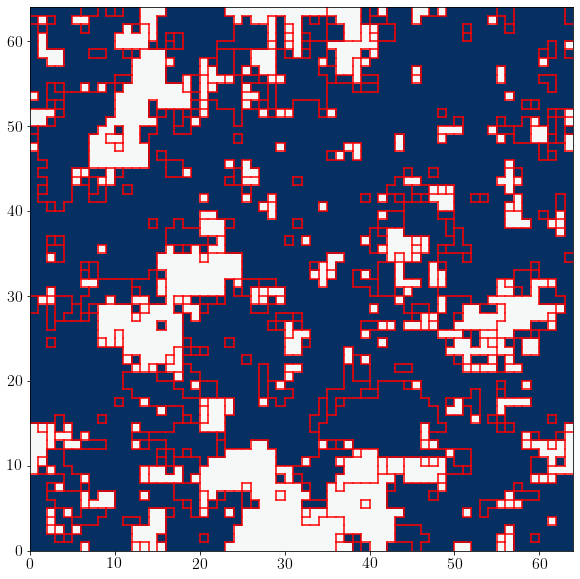

In [73]:
# FK clusters takes lots of time to plot

plot_FK = 1

plt.figure(1, figsize = (10,10))
plt.pcolor(spin.reshape(-1, L).T, cmap = "RdBu", vmin = -3, vmax = 1)
xs, ys =  np.arange(L**2) // L, np.arange(L**2) % L
if plot_FK:
    for k, (i,j) in enumerate(zip(edges.row, edges.col)):
        #diff = spin[1] 
        #d = edges.data[k]
        if FK_clusters[i] == FK_clusters[j]: continue

        z1, z2 = xs[i] +.5 + 1.j*(ys[i]+.5), (xs[j]+.5) + 1.j * (ys[j] + .5)
        if abs(z1 - z2) > 2: continue
        zm = (z1 +z2)/2
        w1 = (z1 - zm) * 1.j + zm
        w2 = 2 * zm - w1
        plt.plot([w1.real, w2.real], [w1.imag, w2.imag], c = "red")
plt.gca().set_aspect('equal')


## Spin spin correlation (two point function)

In [157]:
res_2p = dict()

In [158]:
for lb in [6,7,8]:
    L = 2 ** lb
    print("L = %d" % L)
    full_graph, edges = prepare_graph(L)
    
    w = 2 - 2 ** .5 # critical point
    if not (w, lb) in res_2p:
        spin = np.zeros(L**2, dtype=int)
        rs = np.sort(np.hstack([2 ** np.arange(lb), 3 * 2 ** np.arange(lb-1)]))
        ans = np.zeros(len(rs)+1,)
        res_2p[w,lb] = (rs, ans, spin)
    else:
        rs, ans, spin = res_2p[w,lb]

#get spin clusters
    for j in range(500):
        
        # start from 4-state
        same = (spin[edges.row] == spin[edges.col])  
        #red = (spin[edges.row] + spin[edges.col] == 3)
        edges.data[:] = 0
        edges.data[same] = (rnd.rand(np.sum(same)) < w) # same color: throw a dice
        #edges.data[red] = 1 # 
        FK_graph = edges.tocsc()
        FK_graph.eliminate_zeros()
        n_cl, FK_clusters = sp.csgraph.connected_components(FK_graph, directed=0, return_labels=1)

        FK_spin = rnd.randint(2, size = n_cl) * 2 - 1
        #FK_spin[np.unique(FK_clusters[ind_boundary])] *= 0
        spin[:] = FK_spin[FK_clusters]
        #print(n_cl, end = " ")

        # calculate 2p function
        if ans[0] == 0 and j < 50: continue
        for k,x in enumerate(rs):
            intersect = (spin.reshape(L,L) * np.roll(spin.reshape(L,L), x, axis = 1))
            ans[k+1] += (np.sum(intersect) / L ** 2)
        ans[0] += 1

L = 64
L = 128
L = 256


Comment on the two point functions in different system sizes below. 
Again, remember $\Delta_{\sigma} = 1/8$ in 2D Ising. How is that reflected in the two point function?

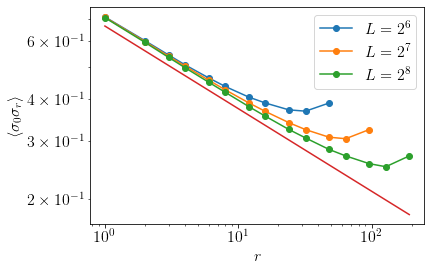

In [160]:
for (w, lb), (rs, ans, spin) in res_2p.items():
    plt.loglog(rs, ans[1:] / ans[0], "o-", label="$L=2^{%d}$" % lb)
   
    plt.xlabel("$r$")
    plt.ylabel(r"$\left< \sigma_{0,0} \sigma_{r,0} \right>$")
plt.plot(rs, rs ** (-1/4) / 1.5)
plt.legend()

The same data, plotted from a long-distance/field theory point of view. 
How do we collapse the data? 

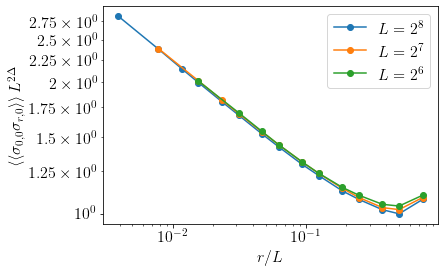

In [162]:
for (w, lb), (rs, ans, spin) in sorted(res_2p.items())[::-1]:
    L =  2 ** lb
    plt.loglog(rs / L, ans[1:] / ans[0] * L ** (.25) , "o-", label="$L=2^{%d}$" % lb )
   
    plt.xlabel("$r / L$")
    plt.ylabel(r"$\left< \left< \sigma_{0,0} \sigma_{r,0} \right> \right> L^{2\Delta}$")
plt.legend()

The quantity of the $y$ axis above is the two-point function of a *scaling operator*, defined as
### $$ \sigma_{\text{scaling}}(x) = \sigma_{\text{lattice}}(r = x L) L^{\Delta_{\sigma}}$$